In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime
import re
import tensorflow as tf
import pickle
from datetime import datetime

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

## 1. Test the trainer

In [ ]:
ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=[64],
    learning_rate=0.0001,
    dropout_rate=0.2,
    lam=0.0001,
    gamma=0.25,
    verbose=True,
    max_epochs=500,
    plot_losses=True,
    dp_sgd=True,
    target_epsilon=3,
    delta=1e-5,
    batch_size=256,
    l2norm_pct=90,
    patience_limit=20,
    c2=1.5
)
autoencoder = ae.train(X_train, X_train_validate)

Noise multiplier: 5.3669
Composed DP event (after 1 steps): achieved epsilon = 0.1015 for delta = 1e-05
Epoch 1 → Train Loss: 29.9424, Val Loss: 29.5733
Epoch 2 → Train Loss: 29.6612, Val Loss: 29.3214
Epoch 3 → Train Loss: 29.4634, Val Loss: 29.0478
Epoch 4 → Train Loss: 29.2415, Val Loss: 28.9831
Epoch 5 → Train Loss: 29.0900, Val Loss: 28.7196
Epoch 6 → Train Loss: 28.9219, Val Loss: 28.6004
Epoch 7 → Train Loss: 28.8224, Val Loss: 28.5696
Epoch 8 → Train Loss: 28.7241, Val Loss: 28.3412
Epoch 9 → Train Loss: 28.6384, Val Loss: 28.3191
Epoch 10 → Train Loss: 28.4954, Val Loss: 27.9169
Composed DP event (after 11 steps): achieved epsilon = 0.1322 for delta = 1e-05
Epoch 11 → Train Loss: 28.1867, Val Loss: 27.7977
Epoch 12 → Train Loss: 28.0548, Val Loss: 27.5918
Epoch 13 → Train Loss: 27.9834, Val Loss: 27.6362
Epoch 14 → Train Loss: 27.8149, Val Loss: 27.2187
Epoch 15 → Train Loss: 27.4360, Val Loss: 26.8543
Epoch 16 → Train Loss: 27.1128, Val Loss: 26.7438
Epoch 17 → Train Loss: 26

## 2. Test the anomaly detector

In [ ]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=ae.lam,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
threshold = np.quantile(scores, 0.8)
y_pred = detector._detect(scores, threshold)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)

{'accuracy': 0.6877891245526753, 'precision': 0.22251308900523561, 'recall': 0.22125813449023862, 'f1_score': 0.221883837285186, 'auc': 0.5156204018324408}


## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [ ]:
# Epsilon = 1
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 1 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=40 --epsilon 1 --delta 1e-5
# Epsilon = 3
# #! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 3 --delta 1e-5 --version 202504152204
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 3 --delta 1e-5 --version 202504152257
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 3 --delta 1e-5 --version 202504152345
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=40 --epsilon 3 --delta 1e-5
# Epsilon = 5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric auc --n_calls=40 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric precision --n_calls=40 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric f1_score --n_calls=40 --epsilon 5 --delta 1e-5
#! cd ..; python3.11 "scripts/dpsgd_model.py" --metric recall --n_calls=40 --epsilon 5 --delta 1e-5

### 3.2. Inspect Convergence of Bayesian Optimization

In [7]:
metric = "f1_score"
version = 202504152141
results_df = pd.read_csv(f"../experiments/hyperparam_tune/dpsgd/bayes_{metric}_{version}.csv")

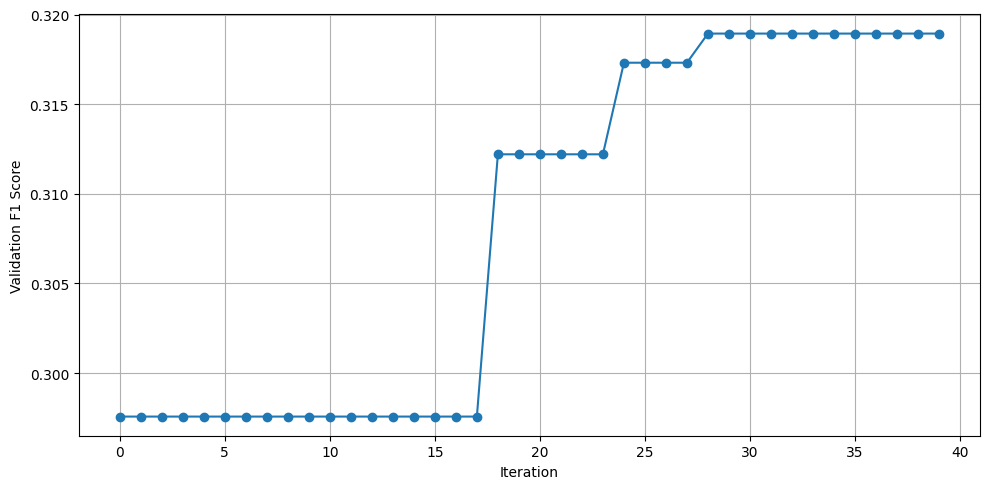

In [8]:
# Compute cumulative best AUC (i.e., convergence plot)
results_df["best_so_far"] = results_df[metric].cummax()

# Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df["best_so_far"], marker='o')
plt.xlabel("Iteration")
plt.ylabel("Validation {}".format(metric.title().replace("_", " ")))
plt.grid(True)
plt.tight_layout()
plt.show()

### 3.3. Compare Models Based on Validation Set

In [3]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=True)
    
# Read the log file
log_path = "../logs/dpsgd_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
display(eval_results)

{'202504152117': ('AUC', '1', '1e-5'), '202504152129': ('Precision', '1', '1e-5'), '202504152141': ('F1 Score', '1', '1e-5'), '202504152153': ('Recall', '1', '1e-5'), '202504152204': ('AUC', '3', '1e-5')}
Evaluating version 202504152117
Evaluating version 202504152129
Evaluating version 202504152141
Evaluating version 202504152153
Evaluating version 202504152204


,accuracy,precision,recall,f1_score,auc,tuned_by,epsilon,delta
version,,,,,,,,
202504152117,0.657327,0.264184,0.393926,0.316266,0.588850,AUC,1,1e-5
202504152129,0.800471,0.516579,0.128416,0.205698,0.605871,Precision,1,1e-5
202504152141,0.650170,0.252255,0.376139,0.301985,0.570750,F1 Score,1,1e-5
202504152153,0.660993,0.270294,0.403037,0.323581,0.593395,Recall,1,1e-5
202504152204,0.641093,0.237125,0.353579,0.283873,0.558693,AUC,3,1e-5


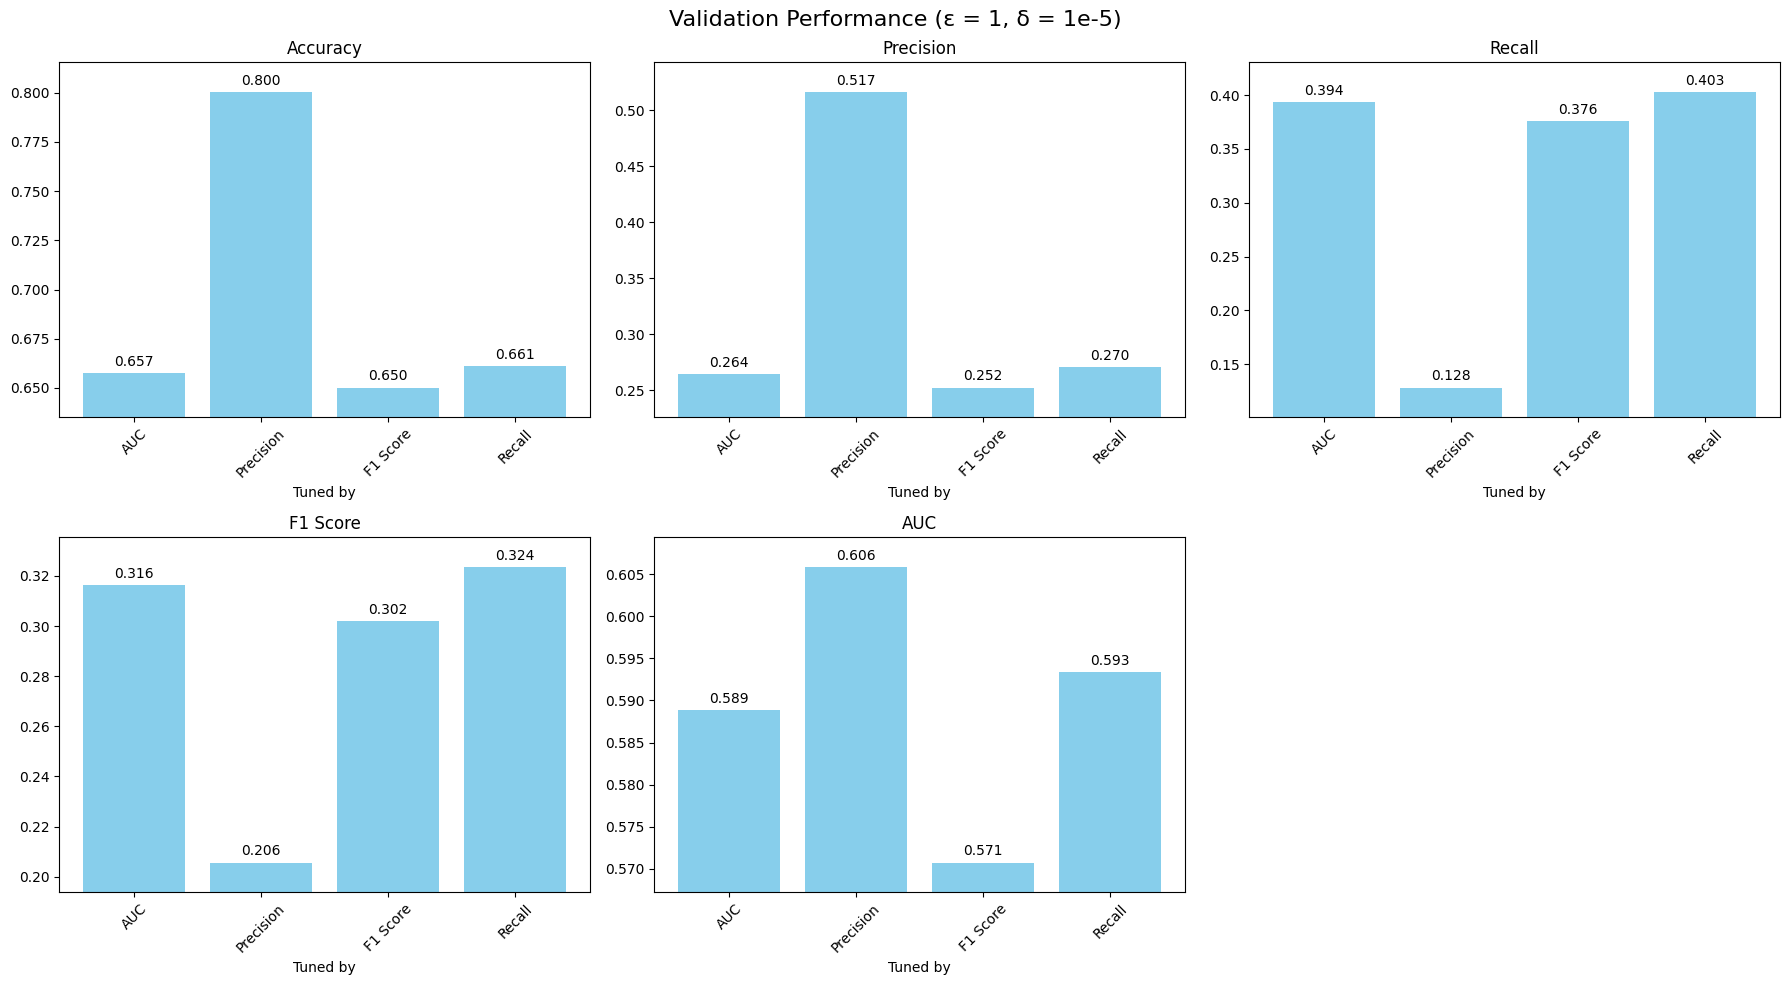

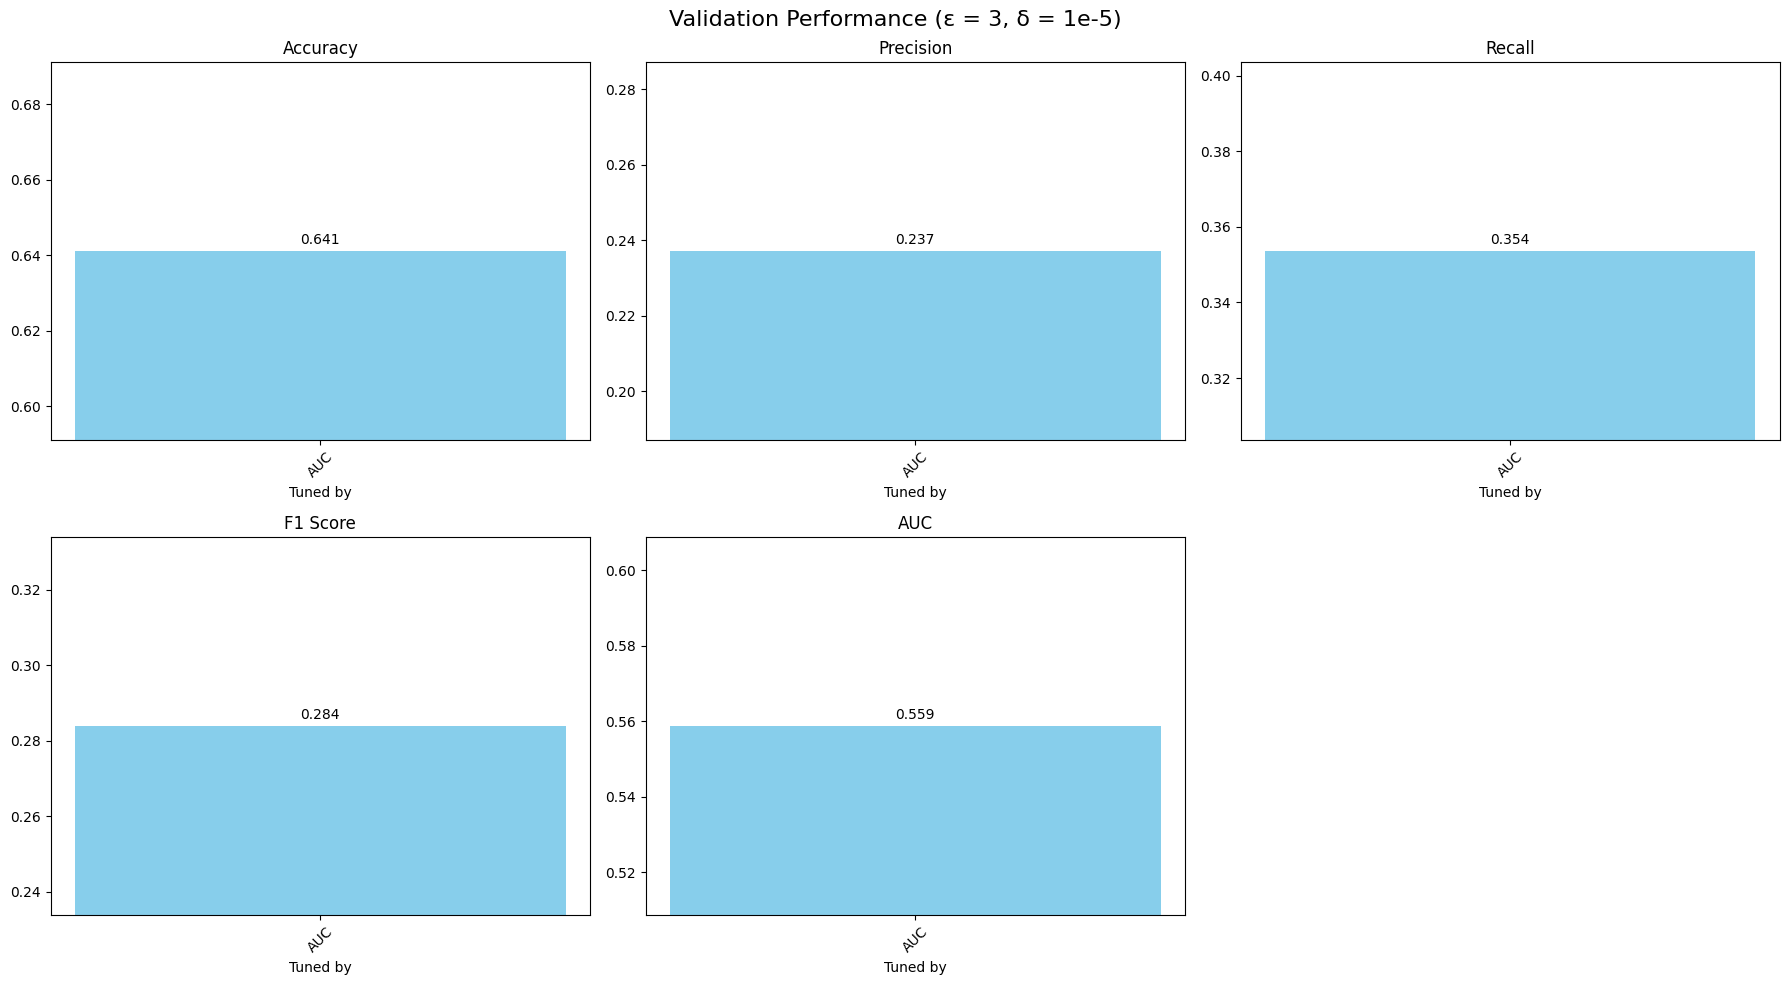

In [4]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

0
1
2
3


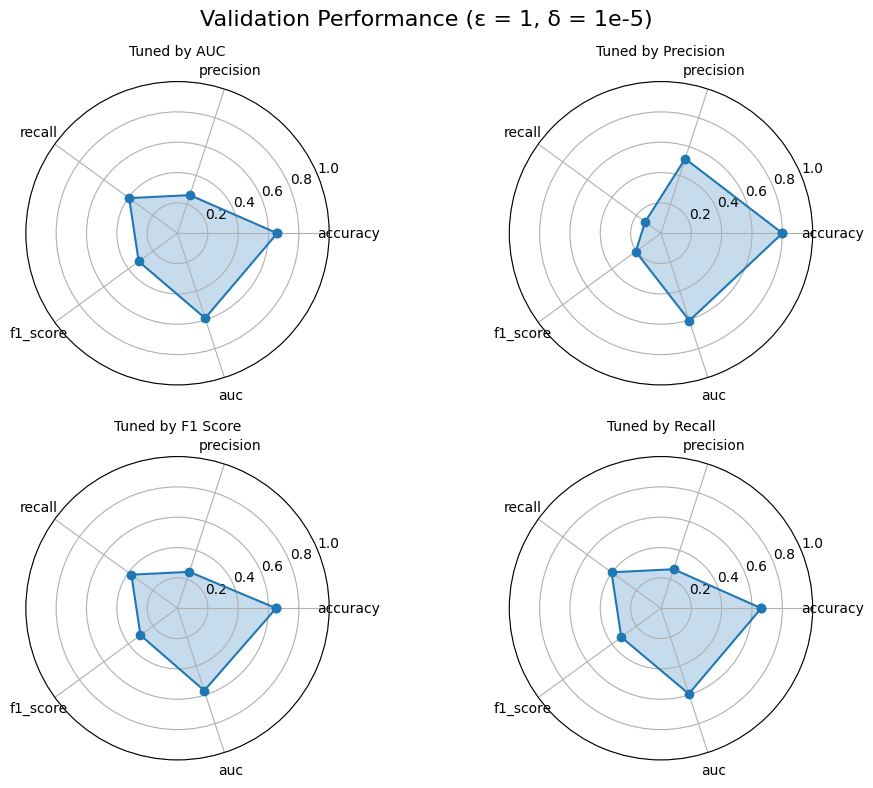

0


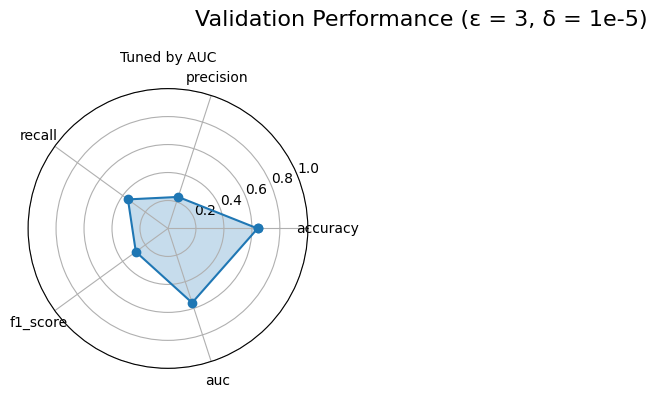

In [5]:
#####################################################
## Plot a radar plot of the validation performance ##
#####################################################
 
valeval.plot_radar(eval_results)

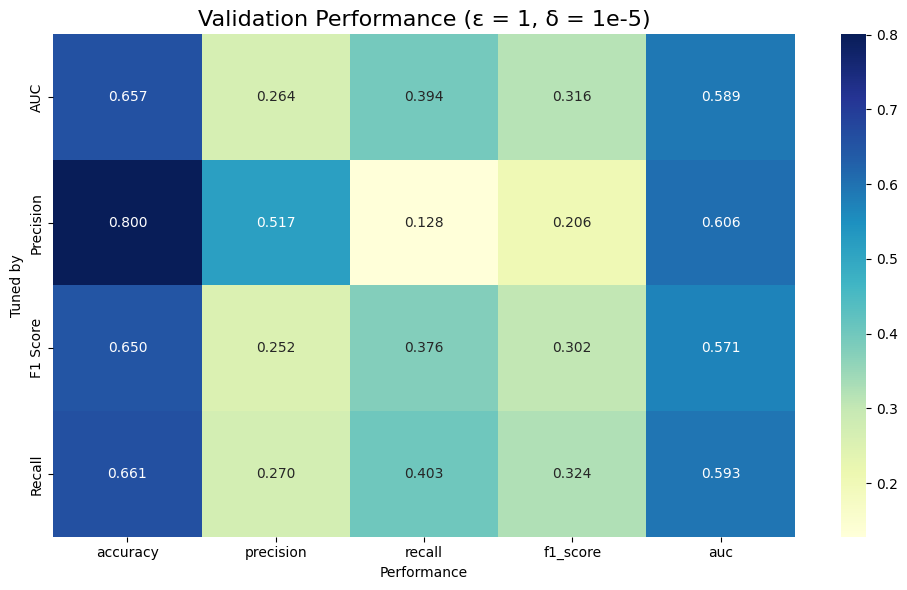

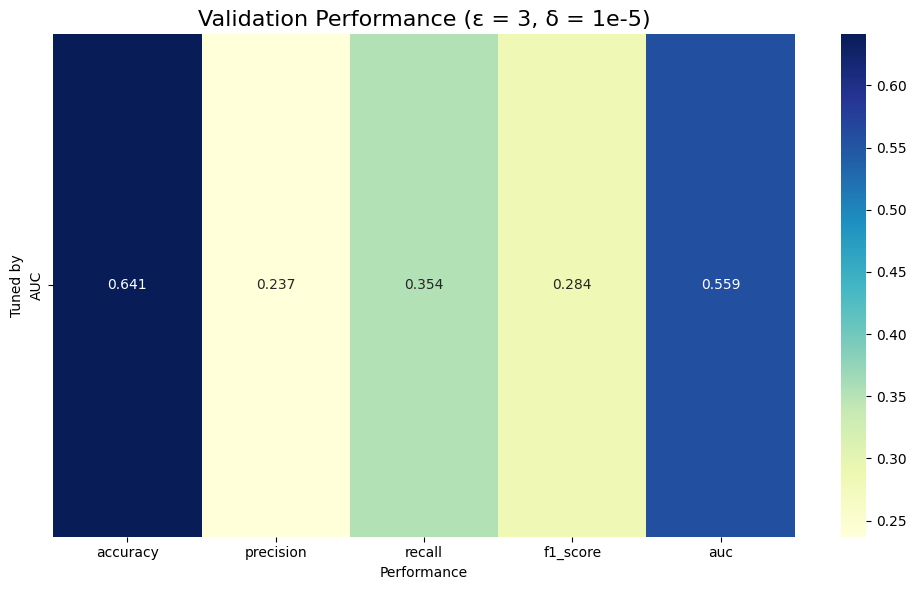

In [6]:
##################################################
## Plot a heatmap of the validation performance ##
##################################################
 
valeval.plot_heatmap(eval_results)